In [1]:
#Lets build the model

import arviz as az
import pymc as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from HelpfulFunctions import clean_and_convert_data

#Notebook settings
pd.set_option("display.max_columns",None)
sns.set_theme()

In [2]:
# load the data

game_df = clean_and_convert_data('game_season_cleaned.csv')
game_df.sample(5)

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,kickoff_date,kickoff_hour,matchgames,previous_points
17384,Manuel Lanzini,MID,West Ham,0.5,0,0,3,0,0.7,460,0.00,0.00,0.00,0.31,254,1,0,0.2,1.6,2023-03-04 15:00:00+00:00,15,5,0,0,0,0,26,0,13321,0,0,4,0.0,1,-72,58,130,51,False,0,26,2023-03-04,15,25,1.0
8770,Connor Ronan,MID,Wolves,-0.2,0,0,0,0,0.0,567,0.00,0.00,0.00,0.00,160,0,0,0.0,0.0,2022-11-12 19:45:00+00:00,0,1,0,0,0,0,16,0,15396,0,2,0,0.0,0,-734,48,782,44,True,0,16,2022-11-12,19,15,1.0
6881,Loris Karius,GK,Newcastle,-0.5,0,0,0,0,0.0,626,0.00,0.00,0.00,0.00,128,0,0,0.0,0.0,2022-10-23 15:30:00+00:00,0,18,0,0,0,0,13,0,6039,0,2,1,0.0,0,40,381,341,40,False,0,13,2022-10-23,15,6,0.0
13693,Nayef Aguerd,DEF,West Ham,2.7,0,0,10,0,0.1,472,0.02,0.29,0.27,0.82,217,1,0,2.5,16.8,2023-02-04 17:30:00+00:00,90,15,0,0,0,0,22,0,14883,1,1,1,8.0,1,3016,3783,767,48,False,1,22,2023-02-04,17,21,6.0
27629,Marek Rodák,GK,Fulham,0.0,0,0,0,0,0.0,213,0.00,0.00,0.00,0.00,363,0,0,0.0,0.0,2023-05-20 14:00:00+00:00,0,7,0,0,0,0,37,0,18230,0,2,2,0.0,0,65,184,119,43,True,0,37,2023-05-20,14,37,0.0


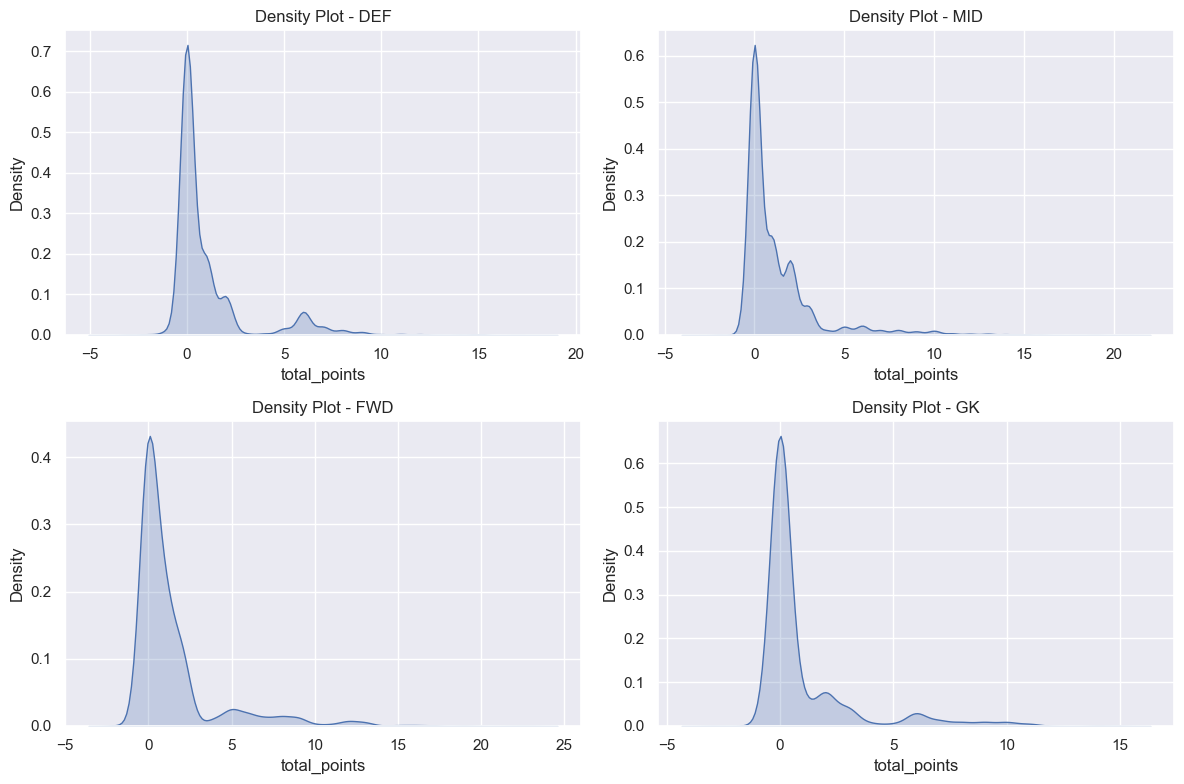

In [4]:
#The concern here is that our target variable has non positive values.
# SInce the aim of the model is to identify high ranking/scoring players, I am not too concerned
# with -ve scores at this point.

# Filter the data for each position
def_data = game_df[game_df['position'] == 'DEF']
mid_data = game_df[game_df['position'] == 'MID']
fwd_data = game_df[game_df['position'] == 'FWD']
gk_data = game_df[game_df['position'] == 'GK']

# Create subplots for each position
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.kdeplot(data=def_data, x='total_points', fill=True)
plt.title('Density Plot - DEF')

plt.subplot(2, 2, 2)
sns.kdeplot(data=mid_data, x='total_points', fill=True)
plt.title('Density Plot - MID')

plt.subplot(2, 2, 3)
sns.kdeplot(data=fwd_data, x='total_points', fill=True)
plt.title('Density Plot - FWD')

plt.subplot(2, 2, 4)
sns.kdeplot(data=gk_data, x='total_points', fill=True)
plt.title('Density Plot - GK')

plt.tight_layout()
plt.show()


In [3]:
# lets try a scatterplot matrix view



# Combine the filtered data into one DataFrame
combined_data = game_df[['position','total_points','team']]



# Create a scatterplot matrix
sns.set(style="ticks")
sns.swarmplot(combined_data, x="total_points", y='position', hue='team')

plt.show()

In [12]:
sns.set_theme(style="ticks")

df = sns.load_dataset("penguins")
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
